## Együttes tanulás

In [32]:
!pip install scipy
!pip install lightgbm

In [33]:
import pandas as pd
import numpy as np 

# Együttes tanulás
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats import mode

cm='viridis' # colormap

# Gradiens turbózás
import lightgbm as lgb # A lightGBM modult fel kell telepíteni
import seaborn as sns
import time
import pydotplus # A pydotplus-t az előző órán feltelepítettük: nem biztos hogy kell, ha van sklearn.tree

# Modellek jóságának mérése
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_breast_cancer
from sklearn.tree import export_graphviz

import matplotlib as mpl
from matplotlib.animation import FuncAnimation # animáciük készítése

mpl.rc('animation', html='jshtml')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Döntési határok felrajzolására függvény

In [34]:
def plot_decision_boundary(clf, X, y, axes=[0, 50, 0, 20], alpha=0.5, contour=True):
    X = np.array(X)
    y = np.array(y)
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    le = preprocessing.LabelEncoder()
    for i in range(len(y_pred)):
        y_pred[i] = le.fit_transform(y_pred[i])
    
    y_pred = y_pred.astype(np.float64)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])    
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.scatter(X[:,0], X[:,1], c=le.fit_transform(y), cmap = custom_cmap2)
    plt.scatter(X[:,0], X[:,1], c=le.fit_transform(y), cmap = custom_cmap2)
    
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

### Adatok beolvasása

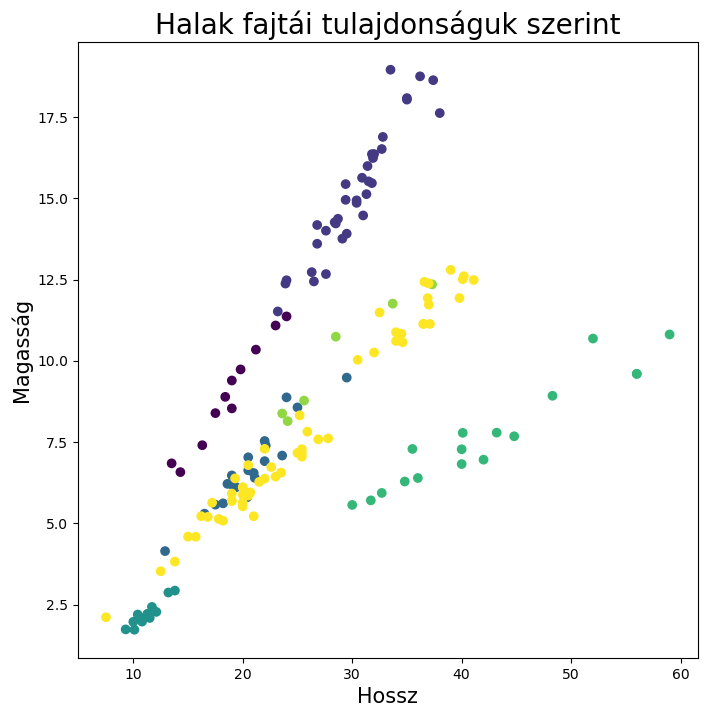

,Faj,Halasz,Csali,Suly,Hossz1,Hossz2,Hossz3,Magassag,Szelesseg,Honos
0,Aranyosfejű,Farkas Gabriella,Csonti,242.0,23.2,25.4,30.0,11.5200,4.0200,Őshonos
1,Aranyosfejű,Farkas Gabriella,Kukac,290.0,24.0,26.3,31.2,12.4800,4.3056,Őshonos
2,Aranyosfejű,Horváth Dénes,Csonti,340.0,23.9,26.5,31.1,12.3778,4.6961,Őshonos
3,Aranyosfejű,Horváth Dénes,Kukorica,363.0,26.3,29.0,33.5,12.7300,4.4555,NaN
4,Aranyosfejű,Horváth Dénes,Kukac,430.0,26.5,29.0,34.0,12.4440,5.1340,Őshonos


In [35]:
df = pd.read_csv('halak.csv', header=0, sep=';', encoding='ISO-8859-2')

X = df[['Hossz1', 'Magassag']] # Független változók
Y = df['Faj'] # Célváltozó

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

le = preprocessing.LabelEncoder() # Címkekódoló a fajták számmal való reprezentálásához

plt.figure(figsize=(8,8))
plt.title("Halak fajtái tulajdonságuk szerint", size=20)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=le.fit_transform(Y), cmap=cm)
plt.xlabel("Hossz", size=15)
plt.ylabel("Magasság", size=15)
plt.show()

df_pred = pd.DataFrame({'original': y_val})

df.head()

### Kétváltozós döntési fa tanítása

In [36]:
clf_tree_2var = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

clf_tree_2var.fit(x_train, y_train)

df_pred['2var_tree'] = clf_tree_2var.predict(x_val) # Predikciók készítése az adathalmazra

print("Accuracy:", accuracy_score(df_pred['original'], df_pred['2var_tree']))
df_pred.head()

Accuracy: 0.78125


,original,2var_tree
78,Sügér,Sügér
155,Bűzöslazac,Bűzöslazac
128,Csuka,Csuka
55,Maréna,Amur
94,Sügér,Sügér


### Bagging

In [37]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), # Milyen modellt használunk
                            n_estimators=500, # Hány modellt tanítson az algoritmus
                            max_samples=120,  # Mennyi mintaegyed különüljön el az egyes modellek tanításának
                            bootstrap=True, 
                            random_state=42)

bag_clf.fit(x_train[['Hossz1','Magassag']], y_train) # tanítás

y_pred_bag = bag_clf.predict(x_val[['Hossz1','Magassag']]) # predikció

df_pred['Bagging'] = y_pred_bag # ellenőrzés
df_pred['Bag_match'] = [1 if x==y else 0 for x,y in zip(df_pred['original'], df_pred['Bagging'])]

print("Accuracy:", accuracy_score(y_val, y_pred_bag))
df_pred.head()

Accuracy: 0.84375


,original,2var_tree,Bagging,Bag_match
78,Sügér,Sügér,Sügér,1
155,Bűzöslazac,Bűzöslazac,Bűzöslazac,1
128,Csuka,Csuka,Csuka,1
55,Maréna,Amur,Bodorka,0
94,Sügér,Sügér,Sügér,1


### Döntési fa vs. Bagging
Figyeljük meg, az adott modellek hogyan partícionálják a teret!

Hasonlítsuk össze a következő tulajdonságuk alapján: alultanulás, túltanulás, generalizálás.

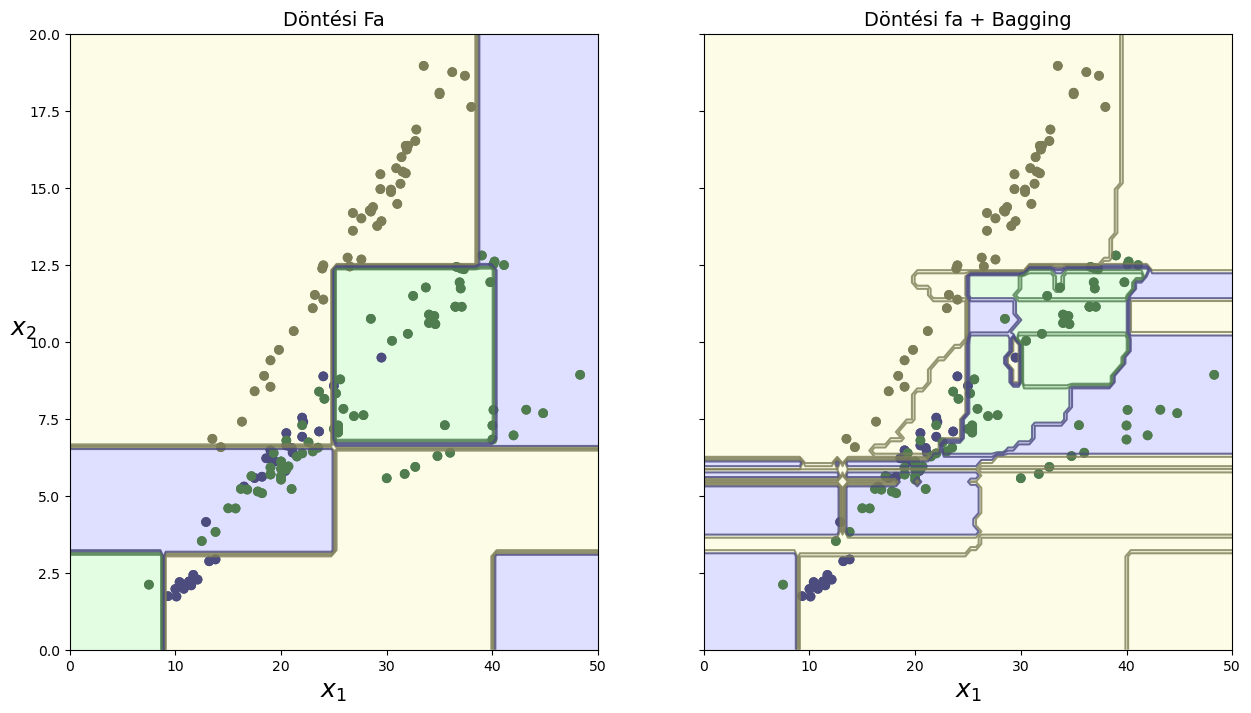

In [38]:
fix, axes = plt.subplots(ncols=2, figsize=(15,8), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(clf_tree_2var, X[['Hossz1', 'Magassag']], Y)
plt.title("Döntési Fa", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X[['Hossz1', 'Magassag']], Y)
plt.title("Döntési fa + Bagging", fontsize=14)
plt.ylabel("")
plt.show()



# Gradiens turbózás rákos sejtek osztályozására
Adatszerkezet felállítása: tumorokról orvosok lejegyezték bizonyos tulajdonságokat, pl. sugár, textúra, kerület stb...

Az adattábla egy jól elemezhető, beépített objektum: sok, numerikus változót tartalmaz, jól jósolható a célváltozó

In [39]:
df = pd.DataFrame(data = load_breast_cancer().data, columns=load_breast_cancer().feature_names)
df['y'] = list(load_breast_cancer().target) # Célváltozó: 1-rákos, 0-nem rákos
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Korrelációs mátrix heatmap-pel

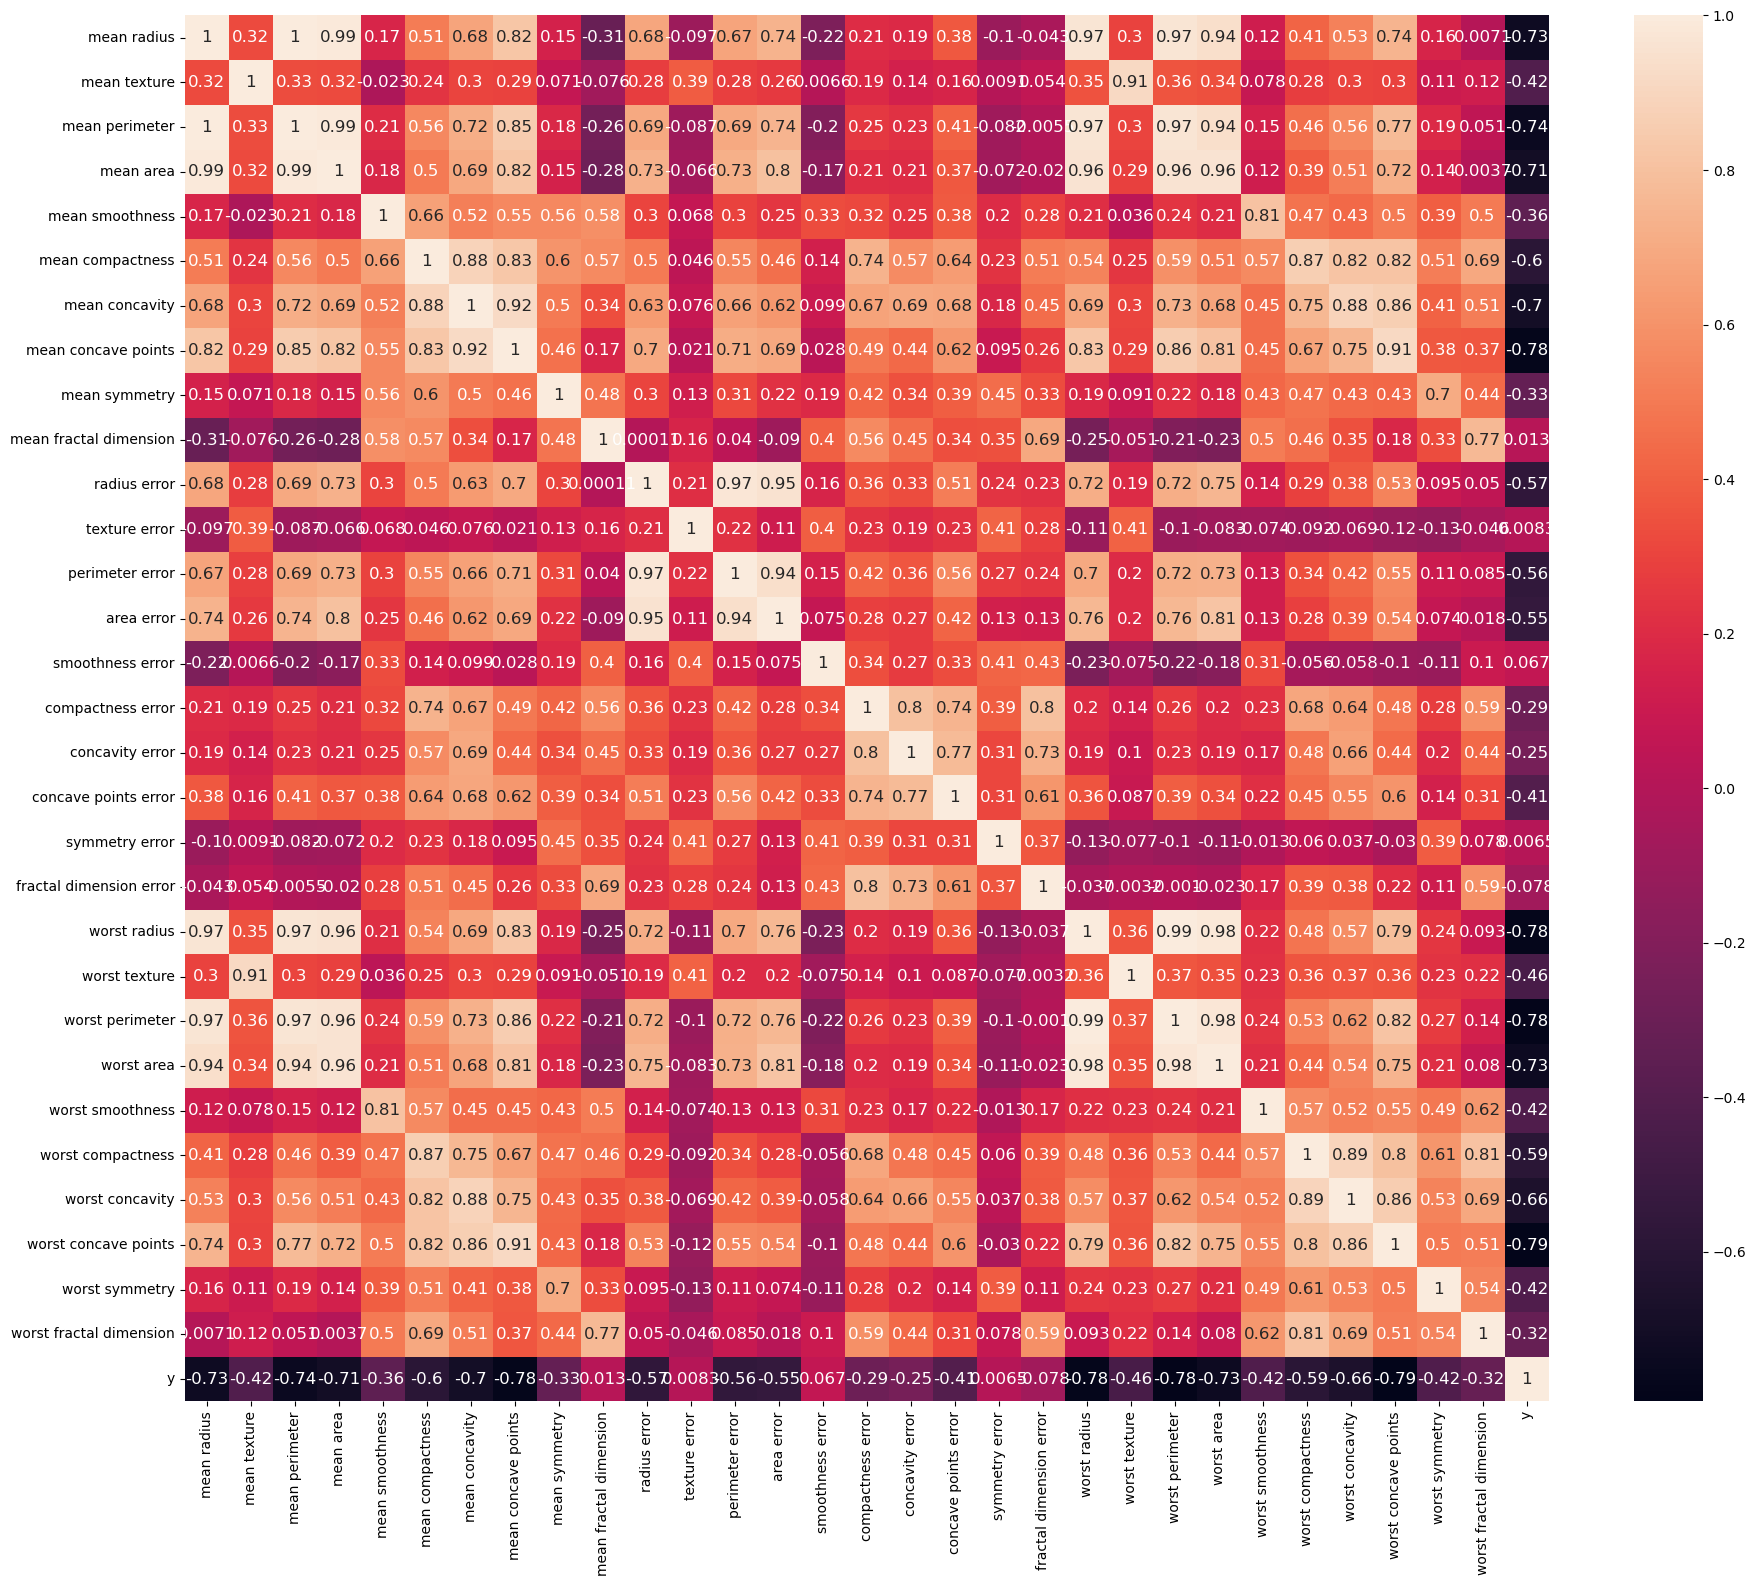

In [40]:
corr = df.corr() 

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, 
            annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(22,18)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Gyenge változók kidobálása
Minden változót eldobunk, ami 0,5-nél gyengébben korrelál a célváltozóval

In [41]:
df = df.drop(list(corr['y'][abs(corr['y'])<0.5].index),axis=1) # Aminek kevesebb mint közepesen erős a korrelációja

### Tanítás-teszt szeparáció 8:2 arányban

In [42]:
mask = np.random.randn(len(df)) < 0.8 # tesztmaszk
x_train = df[mask].iloc[:,:15] 
x_test = df[~mask].iloc[:,:15]
y_train = df[mask].iloc[:,15:]
y_test = df[~mask].iloc[:,15:]

### Paraméterek könyvtára

In [43]:
params = {
    'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
    'objective': 'binary', # Logiszikus
    'num_leaves': 31, # Levelek száma
    'min_data_in_leaf': 20, # Terminális régiókba bekerülő adatmennyiség
    'max_depth': 10, # Elérhető maximális mélység
    'max_bin': 255, # Legtöbb kosár amibe a változó kerülhet
    'learning_rate': 0.1, # Tanulási sebesség
    'metric': [11,12], # Ehhez nem nyúlunk
    'bagging_fraction': 0.8, # Újramintázási mennyiség
    'bagging_freq': 5 # Újramintázási gyakoriság
}

### Függvény egy turbózó tanítására és predikciók lekérésére

In [44]:
def experiment(objective, label_type, x_train, x_test, y_train, y_test, i):
    lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False) # Train LGBM Datasetté alakítása
    lgb_test = lgb.Dataset(x_test, y_test, free_raw_data=False) # Test LGBM Datasetté alakítása
    
    params['objective'] = objective # Célfüggvény
    
    if(i==0):
        gbm = lgb.train(params, # LGBM modell létrehozása
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_test], # Validációs adathalmazok
                        num_boost_round=10) # Hány körös legyen a turbózás
        gbm.save_model(str(objective)+'gbmodel.txt') # Modell mentése
    else:
        gbmprev = lgb.Booster(model_file=str(objective)+'gbmodel.txt') # Előző modell betöltése ha melegindítás
        gbm = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        num_boost_round=10,
                        init_model=gbmprev) # Kezdeti modell megadása, amit tovább kell építenie
        gbm.save_model(str(objective)+'gbmodel.txt') 
      
    y_fitted = pd.Series(gbm.predict(x_test, num_iteration=gbm.best_iteration)) # Predikciók lekérése    
    y_pred = pd.DataFrame({'y_pred': y_fitted}) # Df-é alakítás
     
    y_true = y_test.copy().set_index(np.arange(len(y_test)))
    
    return pd.concat([y_true, y_pred], axis=1)

### Viselkedés vizsgálata bináris és szabadon választott célponttal
Választható: 

    regression, regression_l1, huber, fair, possion, quantile, mape, gamma, tweedie, binary
    multiclass, multiclassova, cross_entropy, cross_entropy_lambda, lambdarank, rank_xendcg

In [45]:
A = [experiment('binary', 'binary', x_train, x_test, y_train, y_test, k) for k in range(10)] # GBDT bináris céllal

second_target = 'tweedie' # Ide kell beírni a célpontot
tree_num = 10
B = [experiment(second_target, 'binary', x_train, x_test, y_train, y_test, k) for k in range(tree_num)] # Másodlagos céllal

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 280, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 15
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642202 -> initscore=0.584934
[LightGBM] [Info]

### Pontosság mérése adott iterációk alatt

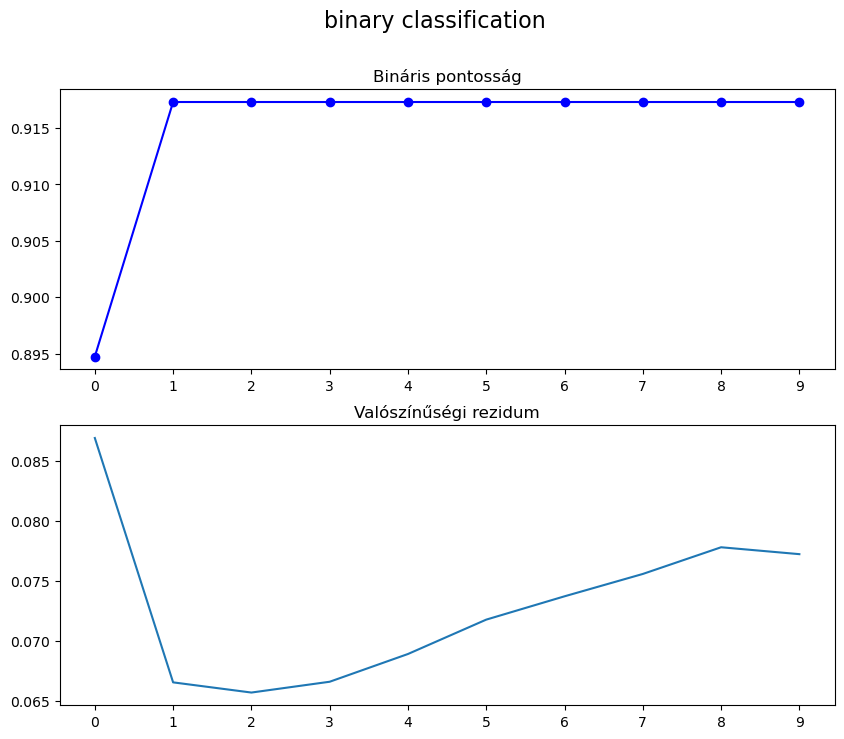

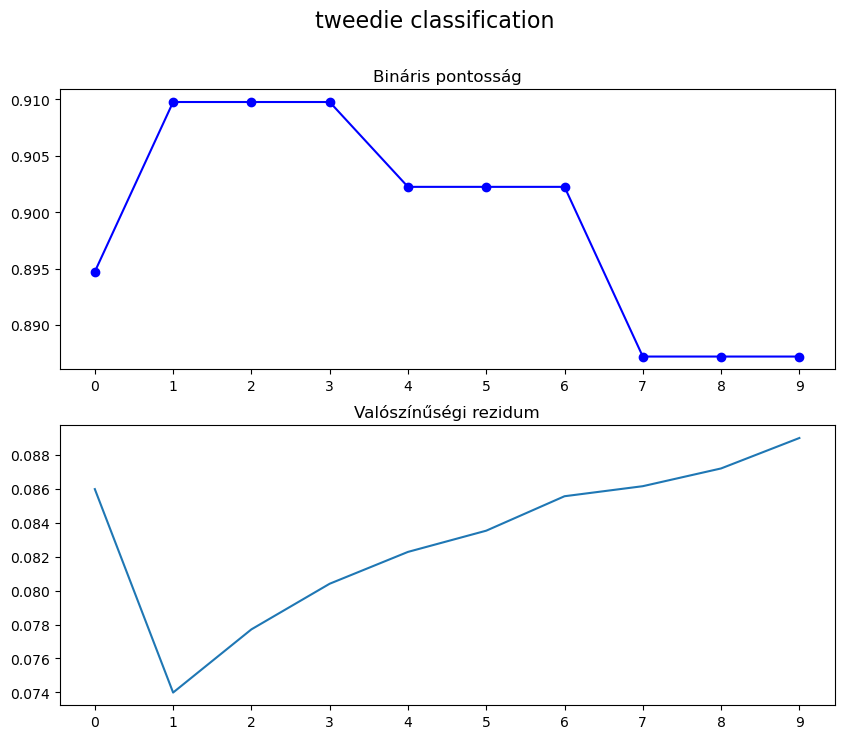

In [46]:
accuracy_binary = lambda D: [accuracy_score(x['y'], x['y_pred'].round()) for x in D] # Adatpontok összerendezése
accuracy_mean = lambda D: [mean_squared_error(x['y'], x['y_pred']) for x in D]

def accplot(accdata, objective): # Pontosságot mérő függvény matplotlib fekete mágiával
    fig = plt.figure(figsize=(10,8))
    ax2 = fig.add_subplot(2,1,2)
    ax1 = fig.add_subplot(2,1,1, sharex=ax2) 
    fig.suptitle(objective + ' classification', fontsize=16)
    ax1.plot(accuracy_binary(accdata), '-ob')
    ax1.set_title('Bináris pontosság')
    ax2.plot(accuracy_mean(accdata))
    ax2.set_title('Valószínűségi rezidum')
    plt.xticks(np.arange(0,len(accdata)))
    plt.show()

accplot(A, 'binary') # Pontosság elsődleges
accplot(B, second_target) # És másodlagos célpontra

### Kontingencia tábla, hőtérkép

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        56
           1       0.90      0.96      0.93        77

    accuracy                           0.92       133
   macro avg       0.92      0.91      0.91       133
weighted avg       0.92      0.92      0.92       133



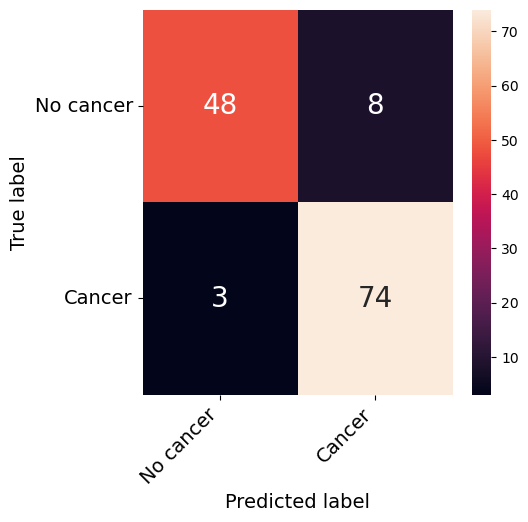

In [47]:
y_predfinal = pd.DataFrame({'pred': A[len(A)-1]['y_pred'].copy().round()})
cmx = confusion_matrix(y_test, y_predfinal) # Ezzel hozza létre. 2 célosztály=2*2 tábla

print(classification_report(y_test, y_predfinal))

plt.figure(figsize=(5,5))
confusion_matrix_df=pd.DataFrame(cmx,('No cancer', 'Cancer'),('No cancer', 'Cancer'))

heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d") # Korrelációs mátrix hőtérképpé
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14) # Tengelycímkék
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize = 14)

plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

### Elemek rendezése
Ez egy segítő függvény

In [48]:
ordergen = lambda D: [x.sort_values(by=['y_pred']).reset_index().drop('index',axis=1) for x in D.copy()]

### Függvény animálása elsődleges célponttal

In [49]:
# Jeleneti változó beállítása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Szekvenciális képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

C = ordergen(A)

fig, ax = plt.subplots(figsize=(15,10)) # Animálandó diagram felvétele
ax.set_xlim(0,len(y_test))
ax.set_ylim(-0.1, 1.1)
ax.set_title('Célpont: bináris')
line, = ax.plot(0,0) # Kirajzolandó vonal létrehozása

x_data = []
y_data = []

def animation_frame(i): # Egyetlen képkocka kirajzolása
    line.set_xdata(np.arange(0,len(C[i]))) # Vonal inícializálása
    fig.suptitle('GBDT Logisztikus regresszió (' + str(i+1)+' fa)', fontsize=20) # Ez a cím miatt kell
    y_data = []
    line.set_ydata(C[i]['y_pred']) # Vonal szerkesztése
    ax.plot(C[0]['y'],'o', color='black') # Diagramra kirajzolás
    return line,

animation = FuncAnimation(fig, func=animation_frame, frames=range(10), interval=200) # Animálás
plt.show()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


### Függvény animálás másodlagos célpontra

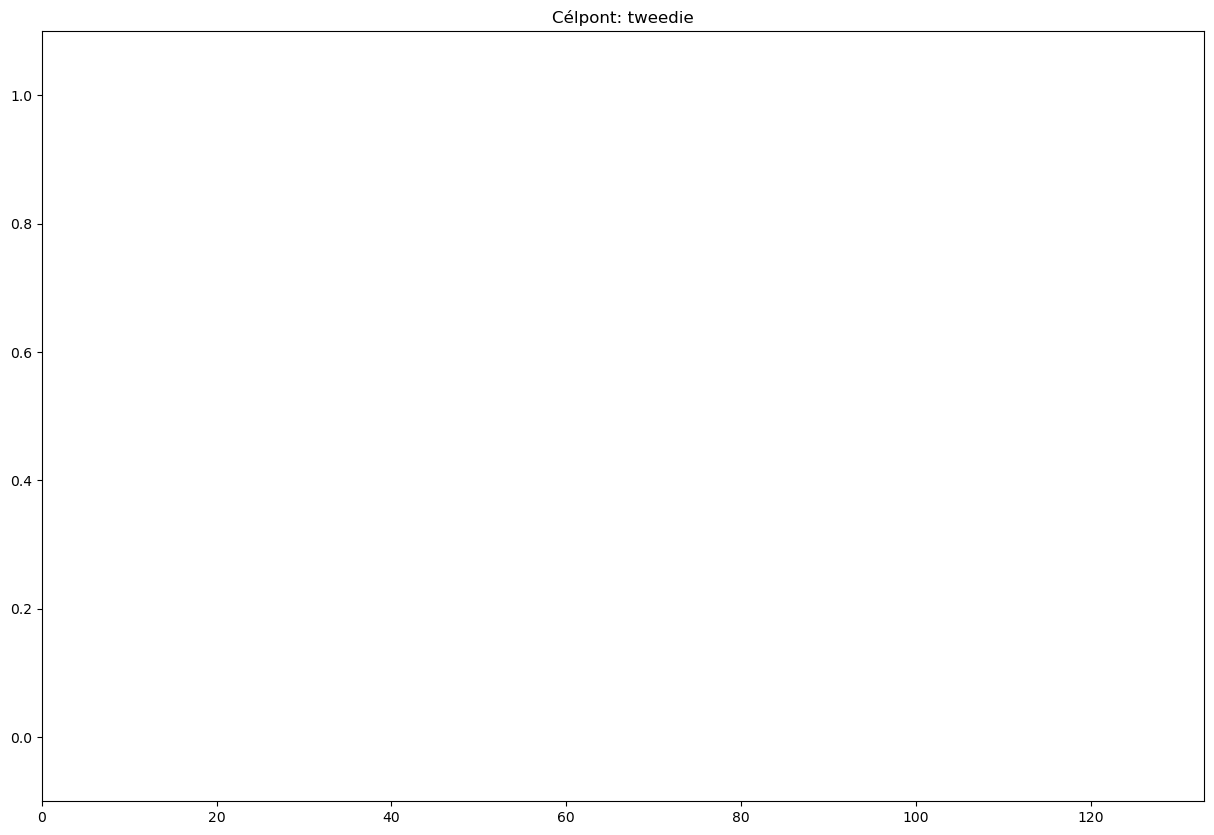

In [53]:
C = ordergen(B)

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim(0,len(y_test))
ax.set_ylim(-0.1, 1.1)
ax.set_title('Célpont: ' + second_target)
line, = ax.plot(0,0)

x_data = []
y_data = []

animation = FuncAnimation(fig, func=animation_frame, frames=range(len(C)), interval=200)
plt.show()

# Egy teljes döntési fa létrehozása az adathalmazra

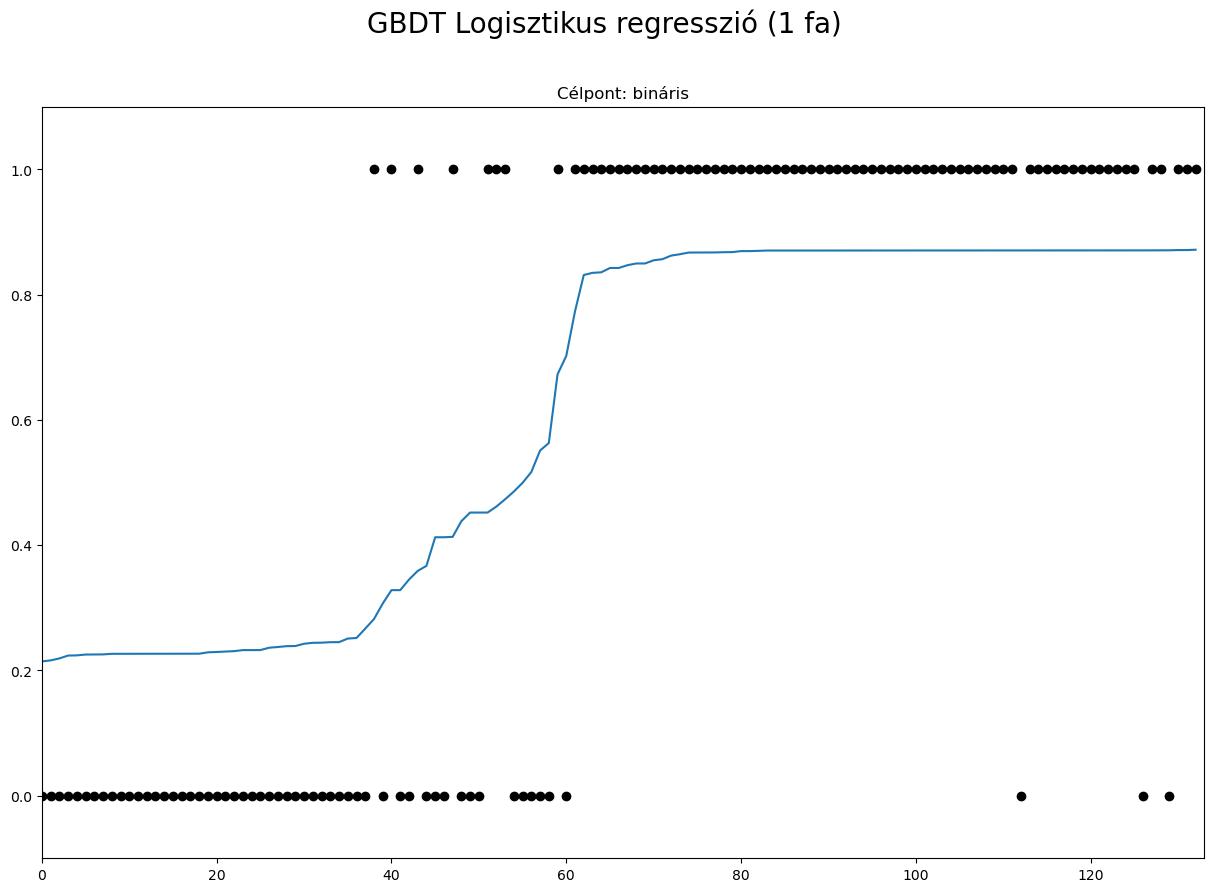

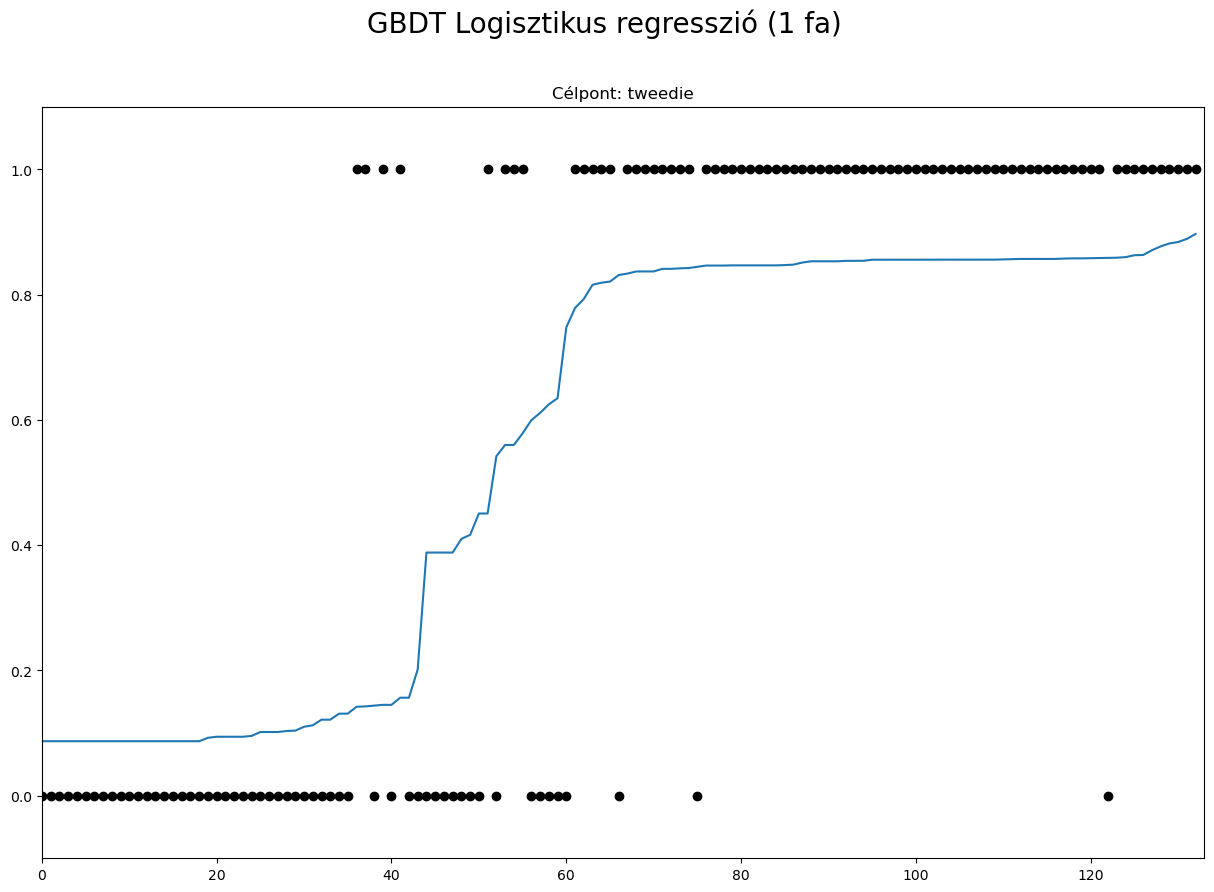

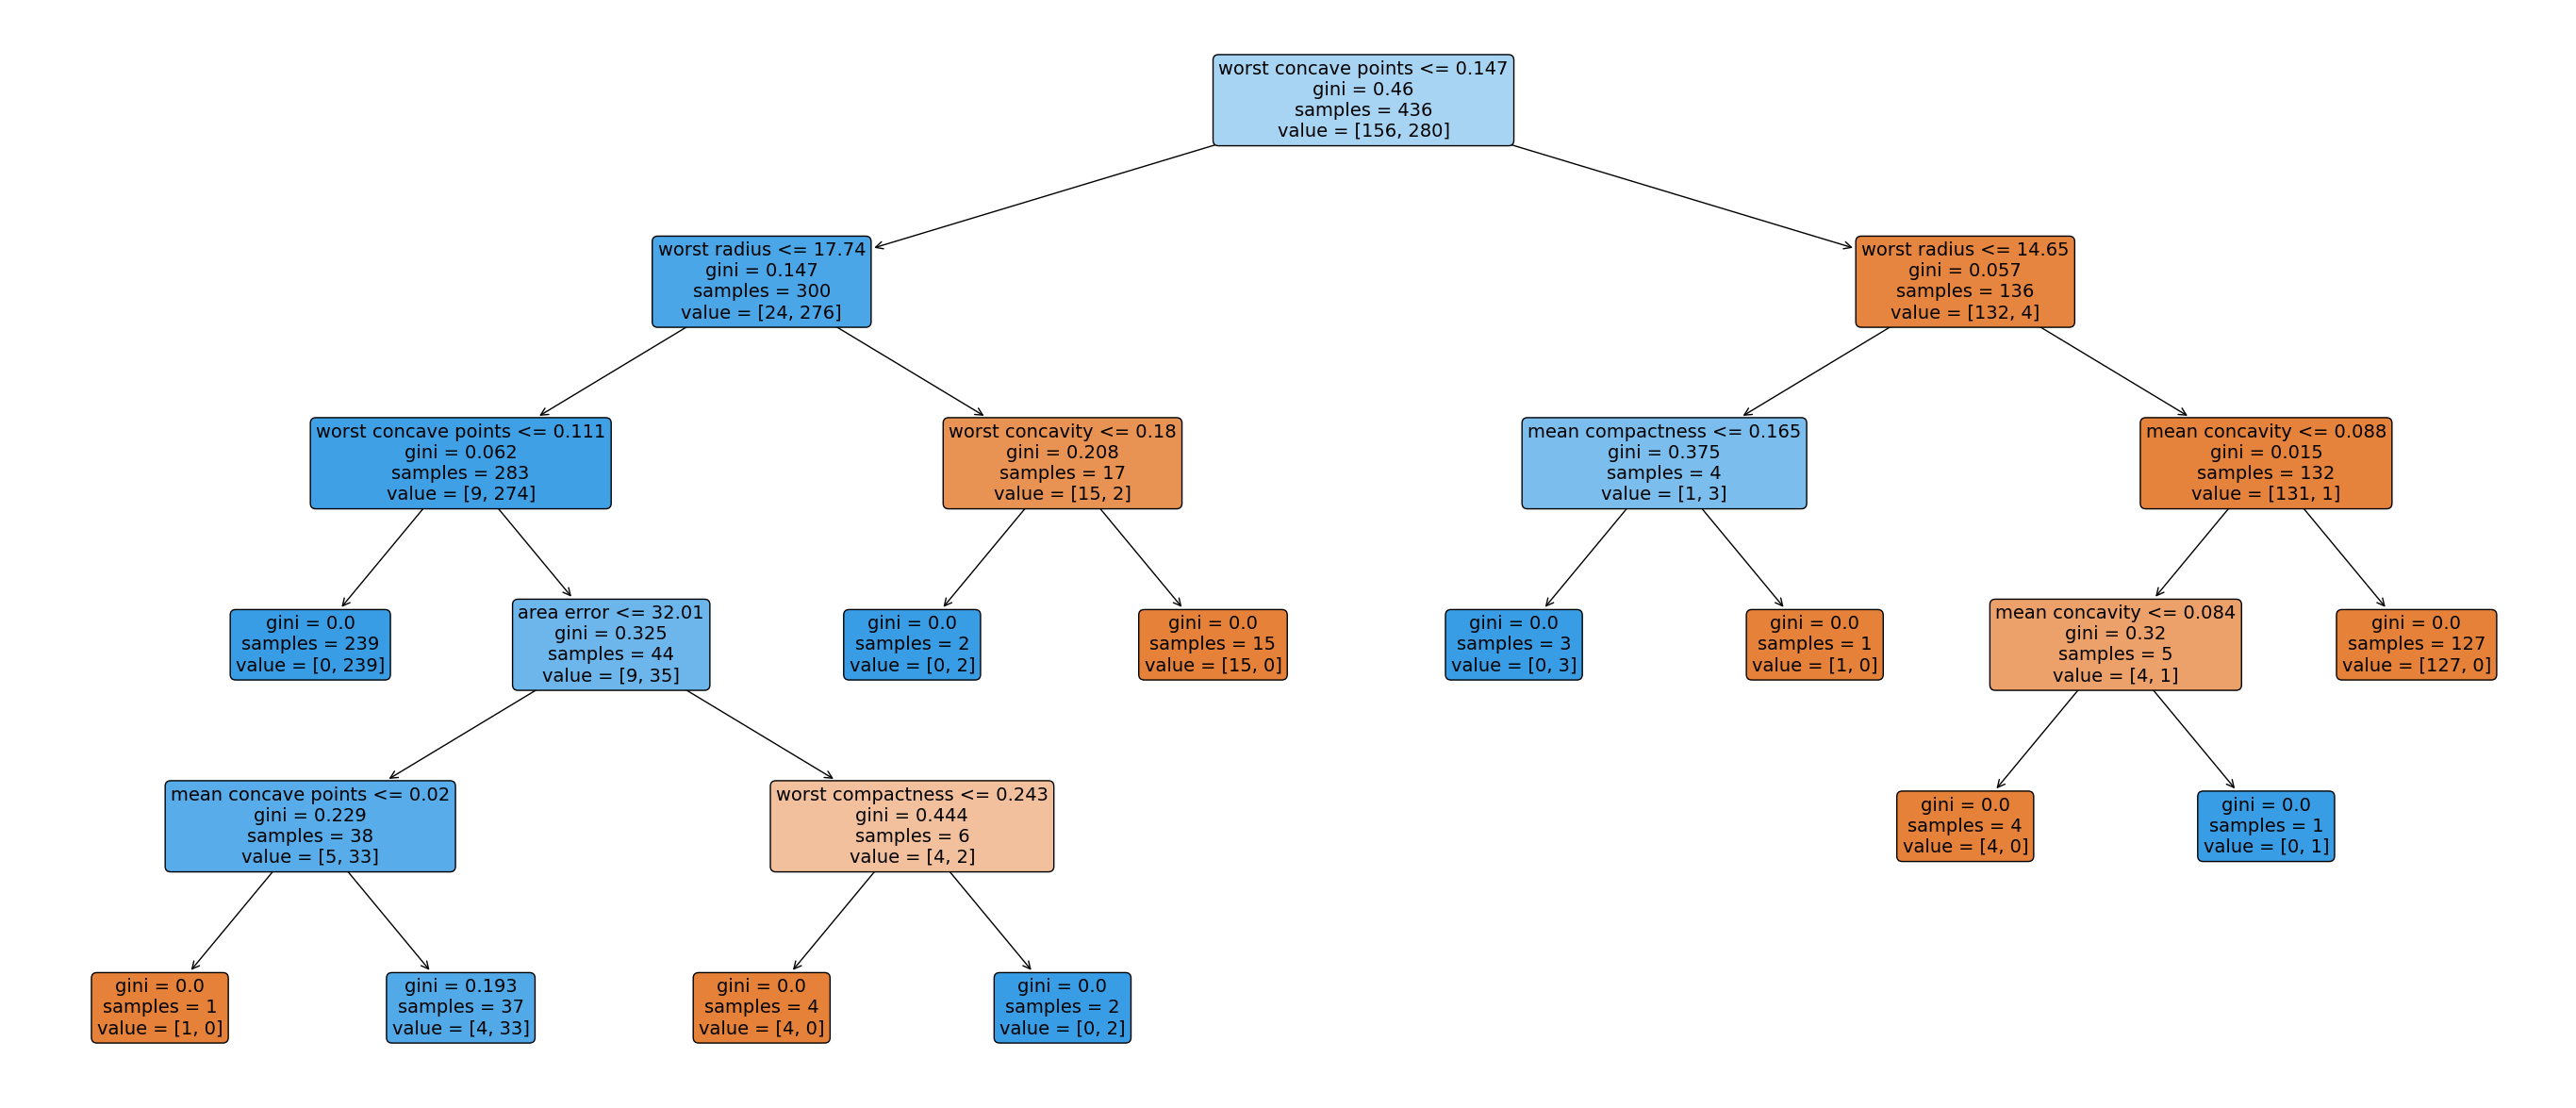

In [51]:
%matplotlib inline
del tree
from sklearn import tree

# Létrehoz egy teljes döntési fát
decisionTree_unpruned = DecisionTreeClassifier()
decisionTree = DecisionTreeClassifier(max_depth=5)

# Döntési fa tanítása az adathalmazra
decisionTree_unpruned = decisionTree_unpruned.fit(X=x_train, y=y_train)
decisionTree = decisionTree.fit(X=x_train, y=y_train)

plt.figure(figsize=(35,15))
tree.plot_tree(decisionTree, filled=True, rounded=True, feature_names = list(x_train.columns), fontsize=14)
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        56
           1       0.86      0.95      0.90        77

    accuracy                           0.88       133
   macro avg       0.89      0.87      0.87       133
weighted avg       0.88      0.88      0.88       133



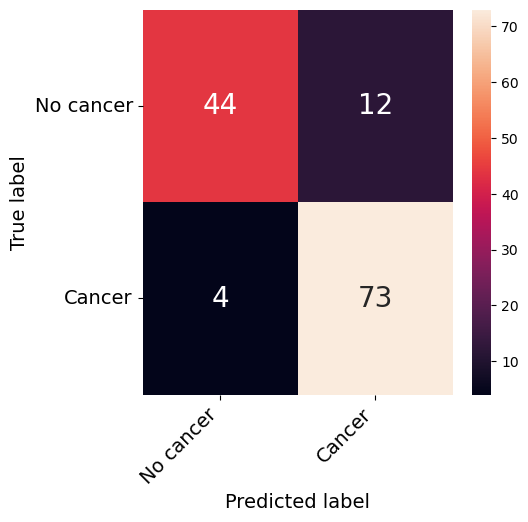

In [52]:
dtree_pred = decisionTree.predict(x_test)
cmx = confusion_matrix(y_test, dtree_pred) # Ezzel hozza létre. 2 célosztály=2*2 tábla

print(classification_report(y_test, dtree_pred))

plt.figure(figsize=(5,5))
confusion_matrix_df=pd.DataFrame(cmx,('No cancer', 'Cancer'),('No cancer', 'Cancer'))

heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d") # Korrelációs mátrix hőtérképpé
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14) # Tengelycímkék
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize = 14)

plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()